In [59]:
import pandas as pd

df_city_hourly = pd.read_csv("dataset/city_hour.csv")
df_city_daily = pd.read_csv("dataset/city_day.csv")
df_station_hourly = pd.read_csv("dataset/station_hour.csv")
df_station_daily = pd.read_csv("dataset/station_day.csv")

C:\Users\sudha\AppData\Local\Temp\ipykernel_12328\2060205937.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_station_hourly = pd.read_csv("dataset/station_hour.csv")


In [60]:
df_city_hourly_list = "City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket"
df_city_daily_list = "City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket"
df_station_hourly_list = "StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket"
df_station_daily_list = "StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket"

In [61]:
df_city_hourly = df_city_hourly.drop(columns=[ 'NH3','City','Datetime','Toluene', 'Xylene', 'AQI_Bucket'], axis=1)
df_city_daily = df_city_daily.drop(columns=[ 'NH3','City','Date','Toluene', 'Xylene', 'AQI_Bucket'], axis=1)
df_station_hourly  = df_station_hourly.drop(columns=[ 'NH3','StationId','Datetime','Toluene', 'Xylene', 'AQI_Bucket'], axis=1)
df_station_daily = df_station_daily.drop(columns=[ 'NH3','StationId','Date','Toluene', 'Xylene', 'AQI_Bucket'], axis=1)

In [62]:
dfs = [df_city_hourly, df_city_daily, df_station_hourly, df_station_daily]
df_merged = pd.concat(dfs, ignore_index=True)

In [63]:
columns_to_fill = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene','AQI']
df_merged[columns_to_fill] = df_merged[columns_to_fill].fillna(df_merged[columns_to_fill].mean())

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
tf.config.run_functions_eagerly(True)

In [65]:
df_merged = df_merged.replace([np.inf, -np.inf], np.nan).dropna()

In [66]:
# df_merged.reset_index(drop=True, inplace=True)

In [67]:
air_quality_features = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene']
X = df_merged['AQI']
y = df_merged[air_quality_features]


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.to_frame())
X_test_scaled = scaler_X.transform(X_test.to_frame())

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("X_train_scaled stats:")
print("Mean:", np.mean(X_train_scaled))
print("Std:", np.std(X_train_scaled))
print("Min:", np.min(X_train_scaled))
print("Max:", np.max(X_train_scaled))

print("\ny_train_scaled stats:")
print("Mean:", np.mean(y_train_scaled))
print("Std:", np.std(y_train_scaled))
print("Min:", np.min(y_train_scaled))
print("Max:", np.max(y_train_scaled))

X_train_scaled stats:
Mean: 5.774348170829826e-16
Std: 1.0000000000000002
Min: -1.3347667549836817
Max: 22.930287825928094

y_train_scaled stats:
Mean: -5.443751430184174e-16
Std: 0.9999999999999988
Min: -0.6300308950339236
Max: 14.426278299713873


In [92]:
y_train.values.reshape(-1, 1)

array([[  4.86      ],
       [149.84231157],
       [ 11.58      ],
       ...,
       [ 12.58352847],
       [ 37.28961406],
       [  3.25695105]])

In [84]:
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

c:\GPU_Code\tf-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
def lr_schedule(epoch):
    return 0.001 * 0.9 ** epoch

In [72]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [73]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(lr_schedule)
    ],
    verbose=1
)

Epoch 1/100


c:\GPU_Code\tf-env\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


68691/68691 ━━━━━━━━━━━━━━━━━━━━ 1444s 21ms/step - loss: 0.9891 - mae: 0.6245 - val_loss: 1.0134 - val_mae: 0.6268 - learning_rate: 0.0010
Epoch 2/100
68691/68691 ━━━━━━━━━━━━━━━━━━━━ 1362s 20ms/step - loss: 0.9906 - mae: 0.6241 - val_loss: 1.0134 - val_mae: 0.6287 - learning_rate: 9.0000e-04
Epoch 3/100
68691/68691 ━━━━━━━━━━━━━━━━━━━━ 1366s 20ms/step - loss: 0.9930 - mae: 0.6249 - val_loss: 1.0136 - val_mae: 0.6332 - learning_rate: 8.1000e-04
Epoch 4/100
68691/68691 ━━━━━━━━━━━━━━━━━━━━ 1365s 20ms/step - loss: 0.9914 - mae: 0.6250 - val_loss: 1.0134 - val_mae: 0.6300 - learning_rate: 7.2900e-04
Epoch 5/100
68691/68691 ━━━━━━━━━━━━━━━━━━━━ 1368s 20ms/step - loss: 0.9976 - mae: 0.6257 - val_loss: 1.0137 - val_mae: 0.6201 - learning_rate: 6.5610e-04
Epoch 6/100
68691/68691 ━━━━━━━━━━━━━━━━━━━━ 1368s 20ms/step - loss: 0.9886 - mae: 0.6239 - val_loss: 1.0134 - val_mae: 0.6268 - learning_rate: 5.9049e-04
Epoch 7/100
68691/68691 ━━━━━━━━━━━━━━━━━━━━ 1367s 20ms/step - loss: 0.9987 - mae: 0.6

In [74]:
loss = model.evaluate(X_test_scaled, y_test_scaled)
print(loss)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 686905
'y' sizes: 6182145


In [80]:
X_test_scaled.shape

(686905, 1)

In [81]:
y_test_scaled.shape

(6182145,)

In [77]:
model.save('model.h5')

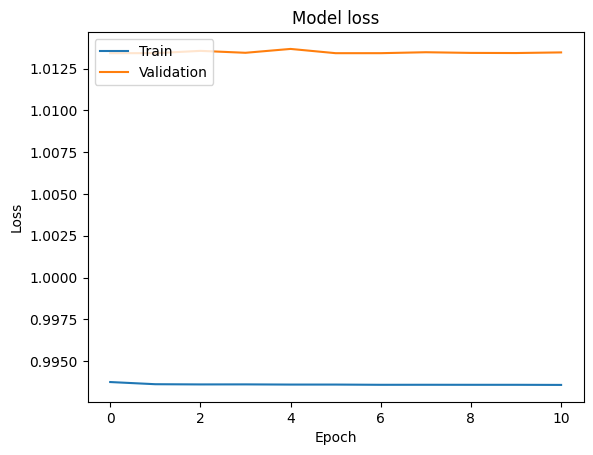

In [78]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [93]:
# scaler = StandardScaler()

scaler = joblib.load('scaler_y.pkl')

user_input = pd.DataFrame({
    'PM2.5': [81],
    'PM10': [124],
    'NO': [1.44],
    'NO2': [20],
    'NOx': [12],
    'NH3': [10],
    'CO': [0.1],
    'SO2': [15],
    'O3': [127],
    'Benzene': [0.20],
    'Toluene': [6],
    'Xylene': [0.06]
})


user_input_scaled = scaler.transform(user_input.values.reshape(-1, 1))

user_pred = model.predict(user_input_scaled)

actual_pred = scaler.inverse_transform(user_pred)

print(user_pred)

print("----------------------------")

print(actual_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[-0.00071763]
 [-0.00071763]
 [-0.00071763]
 [-0.00071763]
 [-0.00071763]
 [-0.00071763]
 [-0.00071763]
 [-0.00071763]
 [-0.00071763]
 [-0.00071763]
 [-0.00071763]
 [-0.00071763]]
----------------------------
[[41.797314]
 [41.797314]
 [41.797314]
 [41.797314]
 [41.797314]
 [41.797314]
 [41.797314]
 [41.797314]
 [41.797314]
 [41.797314]
 [41.797314]
 [41.797314]]


c:\GPU_Code\tf-env\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
